<a href="https://colab.research.google.com/github/sohamgeek/expt-python-for-data-science-skill-sem-4-/blob/main/SKILLLCATRIAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pandas as pd
import os

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1. Loading and Merging the Dataset

In [ ]:

file_paths = [
    "/content/drive/MyDrive/skillLCA/UNSW_2018_IoT_Botnet_Full5pc_1.csv",
    "/content/drive/MyDrive/skillLCA/UNSW_2018_IoT_Botnet_Full5pc_2.csv",
    "/content/drive/MyDrive/skillLCA/UNSW_2018_IoT_Botnet_Full5pc_3.csv",
    "/content/drive/MyDrive/skillLCA/UNSW_2018_IoT_Botnet_Full5pc_4.csv"
]

dfs = [pd.read_csv(path) for path in file_paths]

for i, df in enumerate(dfs):
    print(f"File {i+1} Shape: {df.shape}")
    if len(df) > 25000:
        dfs[i] = df.sample(n=25000, random_state=42)
    else:
        print(f"File {i+1} has less than 25000 rows. Using all.")

df = pd.concat(dfs, ignore_index=True)
print("Combined DataFrame shape:", df.shape)

<ipython-input-3-4b64f39bcdfd>:8: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(path) for path in file_paths]
<ipython-input-3-4b64f39bcdfd>:8: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(path) for path in file_paths]
<ipython-input-3-4b64f39bcdfd>:8: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(path) for path in file_paths]
<ipython-input-3-4b64f39bcdfd>:8: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [pd.read_csv(path) for path in file_paths]


File 1 Shape: (1000000, 46)
File 2 Shape: (1000000, 46)
File 3 Shape: (1000000, 46)
File 4 Shape: (668522, 46)
Combined DataFrame shape: (100000, 46)


# 2. Data Preprocessing – Cleaning the Dataset

In [ ]:
print("Checking for missing values:\n", df.isnull().sum())
print("Checking for duplicates...")
df.drop_duplicates(inplace=True)
print("Duplicates removed. New shape:", df.shape)


Checking for missing values:
 pkSeqID                             0
stime                               0
flgs                                0
flgs_number                         0
proto                               0
proto_number                        0
saddr                               0
sport                               0
daddr                               0
dport                               0
pkts                                0
bytes                               0
state                               0
state_number                        0
ltime                               0
seq                                 0
dur                                 0
mean                                0
stddev                              0
sum                                 0
min                                 0
max                                 0
spkts                               0
dpkts                               0
sbytes                              0
dbytes              

# 3. Data Preprocessing – Encoding Techniques

In [ ]:
non_numeric_cols = df.select_dtypes(include=['object']).columns.tolist()
print("Non-numeric columns:", non_numeric_cols)

for col in non_numeric_cols:
    top_10 = df[col].value_counts().nlargest(10).index
    df[col] = df[col].apply(lambda x: x if x in top_10 else 'other')

df = pd.get_dummies(df, columns=non_numeric_cols)


Non-numeric columns: ['flgs', 'proto', 'saddr', 'sport', 'daddr', 'dport', 'state', 'category', 'subcategory']


# 4. Data Preprocessing – Normalizing, Scaling, Balancing

In [ ]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

# Assuming 'attack' and 'category' were one-hot encoded,
# find the corresponding columns in the DataFrame.
# You might need to adjust the column name patterns based on your data.

# List comprehension to get attack columns if they exist in df
attack_cols = [col for col in df.columns if 'attack_' in col]
category_cols = [col for col in df.columns if 'category_' in col]

# Drop original and one-hot encoded columns if they exist
cols_to_drop = (['attack', 'category'] + attack_cols + category_cols)
cols_to_drop = [col for col in cols_to_drop if col in df.columns]  # keep only if in df

X = df.drop(columns=cols_to_drop)
y = df[category_cols[0]]  # Assuming category has been one-hot encoded, select the first category column for the target


ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

# 5. Data Visualization (Matplotlib) – Part 1

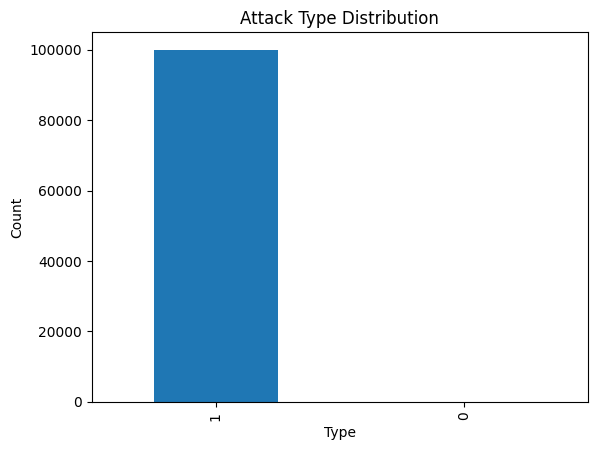

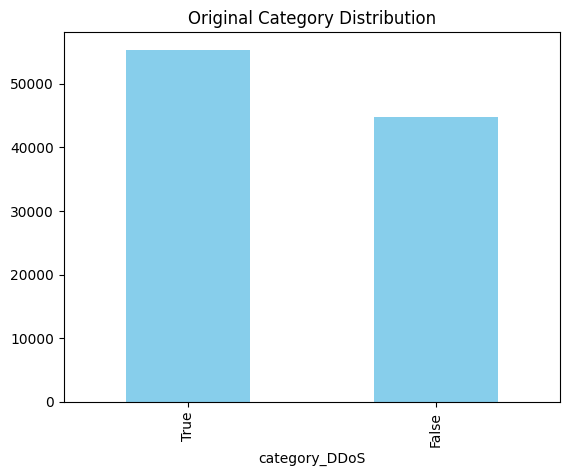

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df['attack'].value_counts().plot(kind='bar')
plt.title('Attack Type Distribution')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

y.value_counts().plot(kind='bar', color='skyblue')
plt.title("Original Category Distribution")
plt.show()


# 6. Data Visualization (Matplotlib) – Part 2

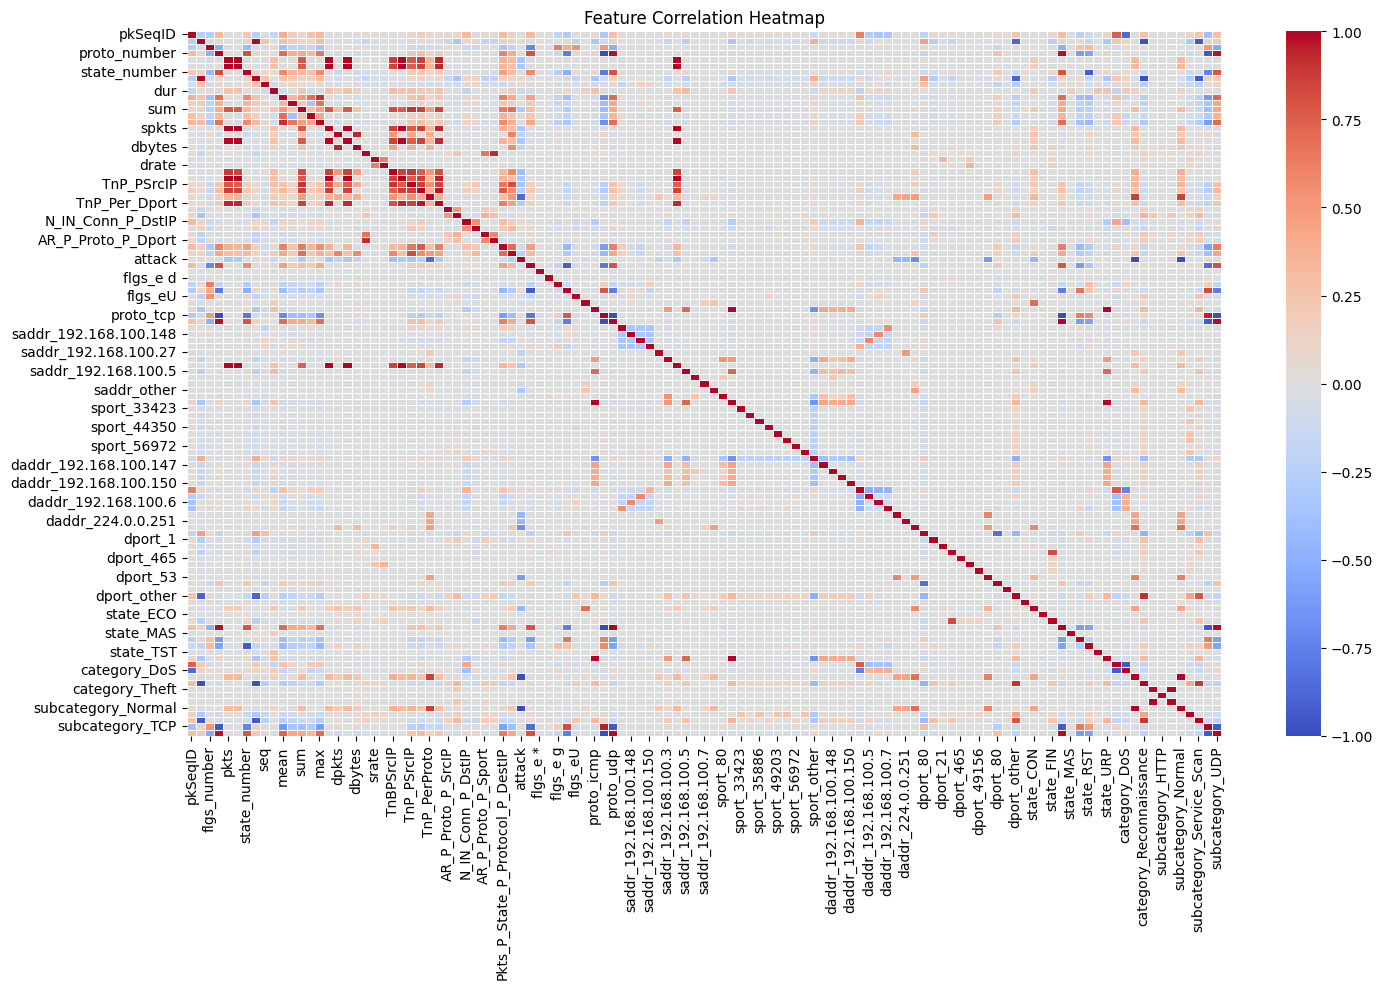

In [ ]:
# Correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


# 7. Apply Filter Feature Selection Techniques – Part 1 (Correlation Thresholding)

In [ ]:
import numpy as np

# Compute correlation matrix
corr_matrix = pd.DataFrame(X_resampled).corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
high_corr_features = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop highly correlated features
X_filtered = pd.DataFrame(X_resampled).drop(columns=high_corr_features)

print(f"Removed {len(high_corr_features)} highly correlated features")



Removed 14 highly correlated features


# 8. Apply Filter Feature Selection Techniques – Part 2 (Univariate Selection- Chi2)


In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

# Using chi-squared to select top 20 features
selector = SelectKBest(score_func=chi2, k=20)
X_kbest = selector.fit_transform(X_filtered, y_resampled)

selected_features = selector.get_support(indices=True)
print("Top 20 selected feature indices:", selected_features)


Top 20 selected feature indices: [ 0  1  6  7 14 15 16 17 18 20 22 23 24 26 27 28 29 62 63 64]


# 9. Apply Wrapper Feature Selection Technique – Part 1 (RFE with Logistic Regression)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

try:
    model = LogisticRegression(max_iter=1000)
    rfe = RFE(model, n_features_to_select=15)
    X_rfe = rfe.fit_transform(X_filtered, y_resampled)

    print("RFE selected feature indices:", np.where(rfe.support_)[0])
except KeyboardInterrupt:
    print("RFE process interrupted by user or system.")
    # Add any cleanup or saving operations you need here.

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

RFE process interrupted by user or system.


# 10. Apply Wrapper Feature Selection Technique – Part 2 (Sequential Feature Selection)10. Apply Wrapper Feature Selection Technique – Part 2 (Sequential Feature Selection)

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
sfs = SequentialFeatureSelector(rf, n_features_to_select=15, direction='forward')
X_sfs = sfs.fit_transform(X_filtered, y_resampled)

print("Sequentially selected feature indices:", np.where(sfs.get_support())[0])


KeyboardInterrupt: 

# 11. Embedded Feature Selection Techniques (Lasso Regularization)

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

lasso = LassoCV(cv=5, random_state=42)
sfm = SelectFromModel(lasso)
sfm.fit(X_filtered, y_resampled)
X_lasso = sfm.transform(X_filtered)

print("Lasso selected feature indices:", np.where(sfm.get_support())[0])


Lasso selected feature indices: []


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_base.py:122: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(


# 12. Using Different ML Supervised Classifiers

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

# Reduce the strength of regularization by increasing max_iter
lasso = LassoCV(cv=5, random_state=42, max_iter=10000)  # Increased max_iter

sfm = SelectFromModel(lasso)
sfm.fit(X_filtered, y_resampled)
X_lasso = sfm.transform(X_filtered)

# Check if any features were selected
if X_lasso.shape[1] == 0:
    print("Warning: Lasso regularization removed all features. Consider adjusting parameters.")
    # Option 1: Use a lower threshold for feature selection:
    # sfm = SelectFromModel(lasso, threshold=1e-5) # Example threshold
    # X_lasso = sfm.transform(X_filtered)

    # Option 2: Continue with original (unfiltered) data:
    # X_lasso = X_filtered

print("Lasso selected feature indices:", np.where(sfm.get_support())[0])

Lasso selected feature indices: []


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_base.py:122: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
